In [1]:
f = open('AsianReligionsData/Complete_data .txt')
content = f.read()
lines = content.split("\n")
data = []

# wybranie tylko linii z danymi
for i in range(len(lines)):
    if i % 2 == 1:
        data.append(lines[i])

f.close()

In [2]:
import string
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

def process_whole_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens
    
def get_first_i_without_order(text, i, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
        
    freq = FreqDist(tokens)
    most_comm = freq.most_common(i)
    tokens = [token[0] for token in most_comm]
    
    return tokens

In [3]:
from scipy.spatial import distance
import numpy as np

# def two_class

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)


In [4]:
def prepare_X(texts, process_function):
    vectorizer = TfidfVectorizer(tokenizer=process_function,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    return vectorizer.fit_transform(texts)

In [27]:
from sklearn import cluster, datasets, mixture
import pandas as pd
from functools import partial
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

X = prepare_X(data, process_whole_text).toarray()
metrices = {
            'min dist between clusters': min_interclust_dist,
            'mean dist in clust': mean_inclust_dist,
            'std dev dist in clust': std_dev_of_inclust_dist,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score
           }

dbscan = cluster.DBSCAN()
labels = dbscan.fit_predict(X)
for metric in metrices:
    print(metric, ": ", metrices[metric](X, labels))

/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


min dist between clusters :  0.533468594684705
mean dist in clust :  0.9151645778263173
std dev dist in clust :  0.40557104500840585
mean dist to clust center :  0.6334987160065775
silhouette :  -0.030633029041744725


In [28]:
from collections import Counter
Counter(labels).keys()

dict_keys([-1, 0])

In [59]:
eps_list = np.arange(0.1, 1, 0.1)
df = pd.DataFrame()
for eps in eps_list:
    # print("EPS: ", eps)
    dbscan = cluster.DBSCAN(eps=eps)
    labels = dbscan.fit_predict(X)
    df.loc[eps, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[eps, metric_key] =  metrices[metric_key](X, labels)
        except:
            print(":(", metric_key, eps)
df

:( silhouette 0.1
:( silhouette 0.2
:( silhouette 0.30000000000000004
:( silhouette 0.4


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
0.1,1.0,inf,1.319530,0.000000,0.933880,NaN
0.2,1.0,inf,1.319530,0.000000,0.933880,NaN
0.3,1.0,inf,1.319530,0.000000,0.933880,NaN
0.4,1.0,inf,1.319530,0.000000,0.933880,NaN
0.5,2.0,0.533469,0.915165,0.405571,0.633499,-0.030633
0.6,3.0,0.548840,0.865496,0.323055,0.596172,-0.022660
0.7,5.0,0.633533,0.850090,0.249306,0.573131,-0.029162
0.8,7.0,0.649848,0.891919,0.199291,0.601810,-0.005624
0.9,10.0,0.710173,1.000851,0.164401,0.677092,0.037307


## Standaryzacja

In [31]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
eps_list = np.arange(0.1, 1, 0.1)

df = pd.DataFrame()
for eps in eps_list:
    # print("EPS: ", eps)
    dbscan = cluster.DBSCAN(eps=eps)
    labels = dbscan.fit_predict(X_scaled)
    df.loc[eps, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[eps, metric_key] =  metrices[metric_key](X_scaled, labels)
        except:
            print(":(", metric_key, eps)
df

:( silhouette 0.1
:( silhouette 0.2
:( silhouette 0.30000000000000004
:( silhouette 0.4
:( silhouette 0.5
:( silhouette 0.6
:( silhouette 0.7000000000000001
:( silhouette 0.8
:( silhouette 0.9


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center
0.1,1.0,inf,15.151905,0.0,10.674815
0.2,1.0,inf,15.151905,0.0,10.674815
0.3,1.0,inf,15.151905,0.0,10.674815
0.4,1.0,inf,15.151905,0.0,10.674815
0.5,1.0,inf,15.151905,0.0,10.674815
0.6,1.0,inf,15.151905,0.0,10.674815
0.7,1.0,inf,15.151905,0.0,10.674815
0.8,1.0,inf,15.151905,0.0,10.674815
0.9,1.0,inf,15.151905,0.0,10.674815


In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)
pca_df = pd.DataFrame(data = pca_X, columns = ['col1', 'col2'])

def printdbscan(eps):
    dbscan = cluster.DBSCAN(eps=eps)
    labels = dbscan.fit_predict(X)
    pca_df['c'] = labels
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="col1", y="col2",
        hue="c",
        palette=sns.color_palette("hls", len(set(labels))),
        data=pca_df,
        legend="full",
        alpha=0.7
    ).set_title(eps)

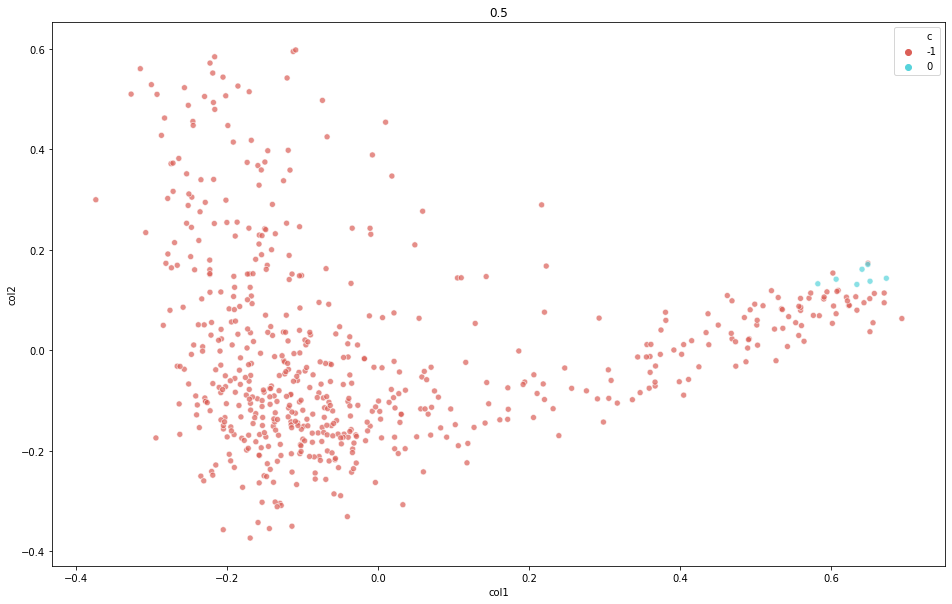

In [53]:
printdbscan(0.5)

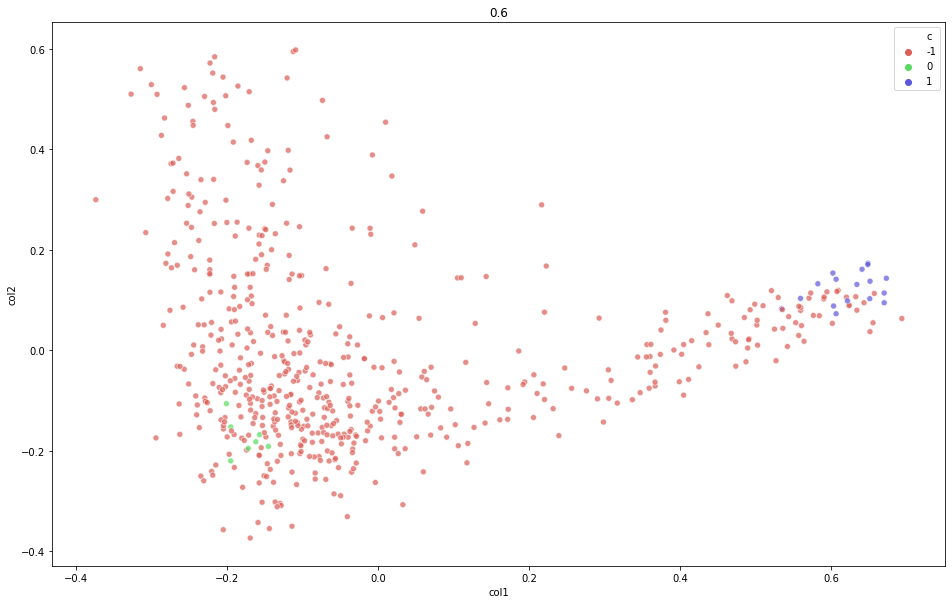

In [54]:
printdbscan(0.6)

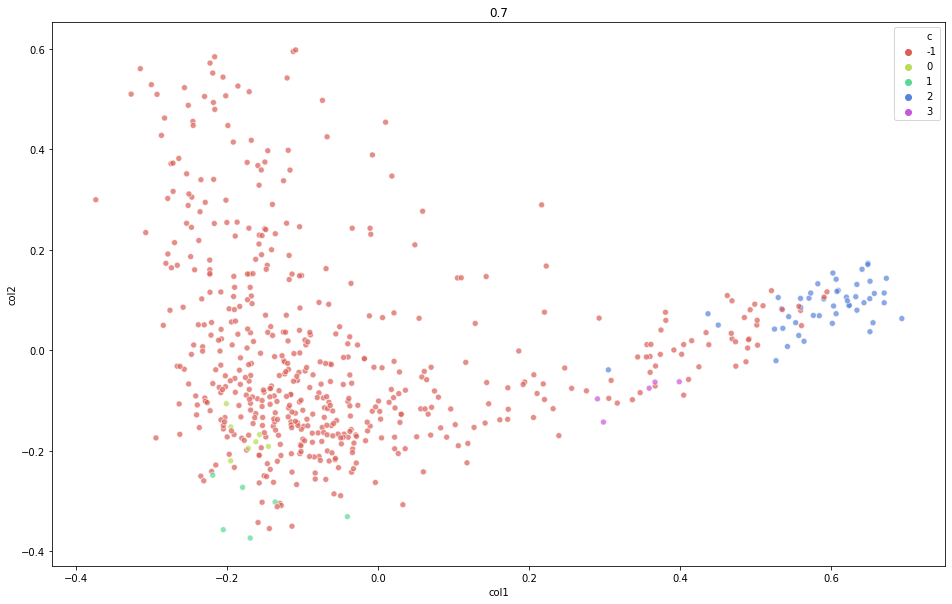

In [55]:
printdbscan(0.7)

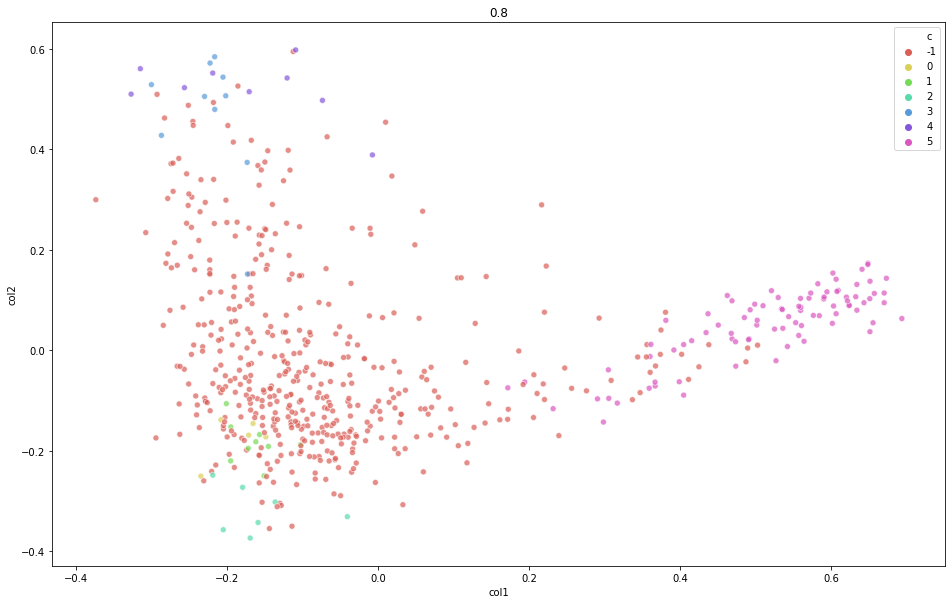

In [56]:
printdbscan(0.8)

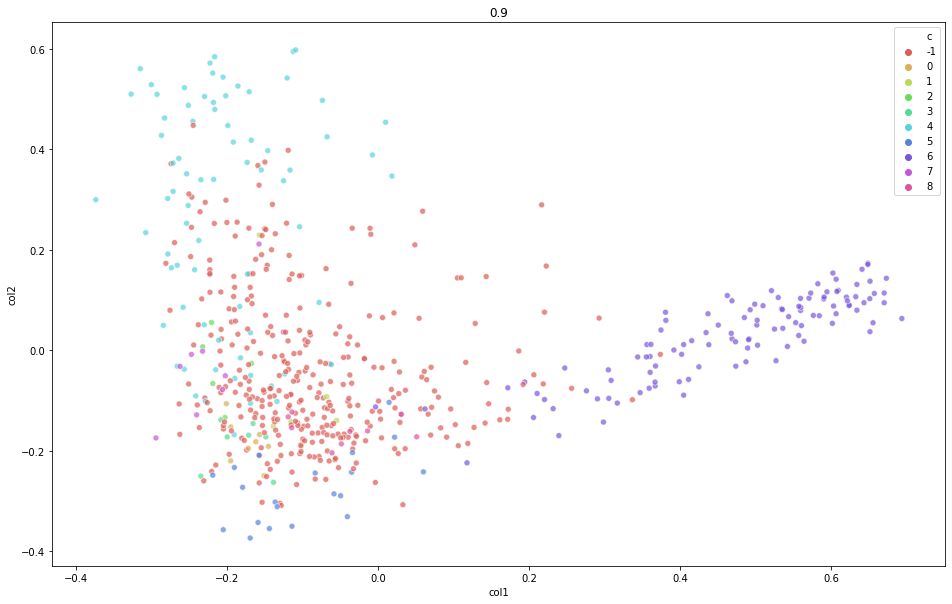

In [57]:
printdbscan(0.9)

# GMM

In [64]:
df = pd.DataFrame()
for n in range(1,10):
    gmm = mixture.GaussianMixture(n_components=n)
    labels = gmm.fit_predict(X)
    df.loc[n, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[n, metric_key] =  metrices[metric_key](X, labels)
        except:
            print(":(", metric_key, n)
df

:( silhouette 1


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
1,1.0,inf,1.319530,0.000000,0.933880,NaN
2,2.0,0.767523,1.183476,0.149325,0.835472,0.044869
3,3.0,0.637202,1.195421,0.127095,0.843467,0.054196
4,4.0,0.567902,1.207983,0.114364,0.851789,0.057879
5,5.0,0.567902,1.217863,0.114395,0.858822,0.060623
6,6.0,0.567902,1.210889,0.106204,0.853125,0.061266
7,7.0,0.567902,1.199706,0.103207,0.843290,0.058775
8,8.0,0.567902,1.199730,0.106561,0.843736,0.056131
9,9.0,0.565607,1.188358,0.117580,0.834556,0.048883


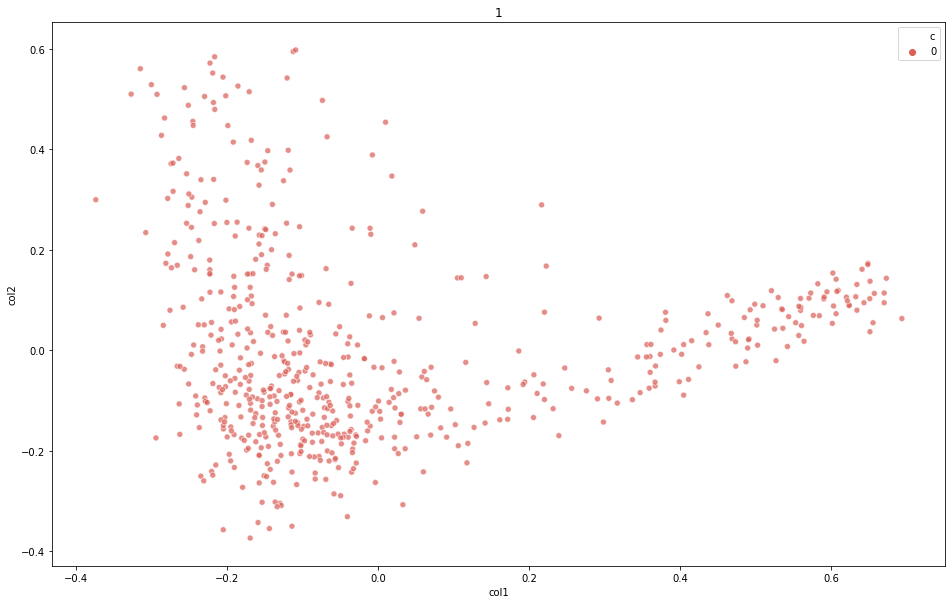

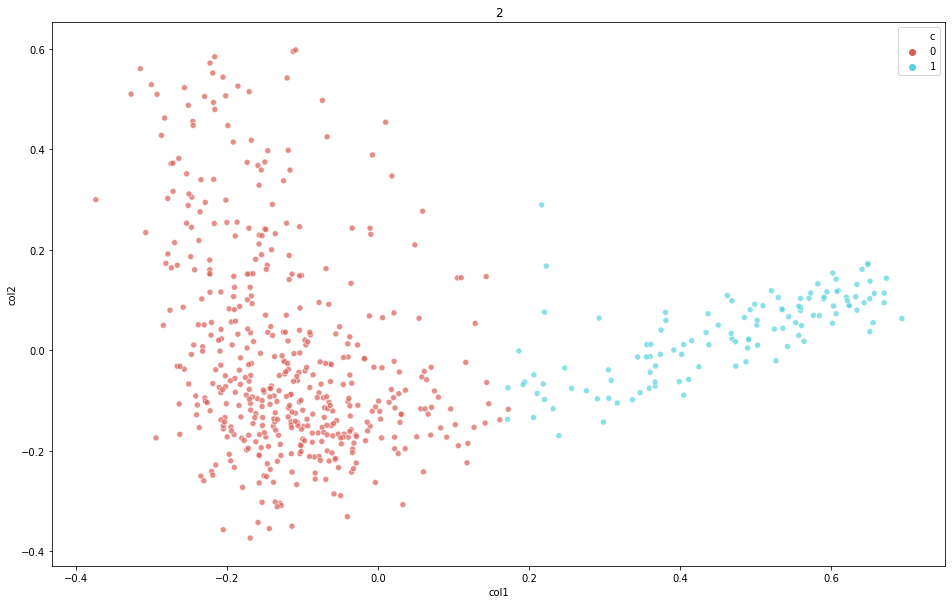

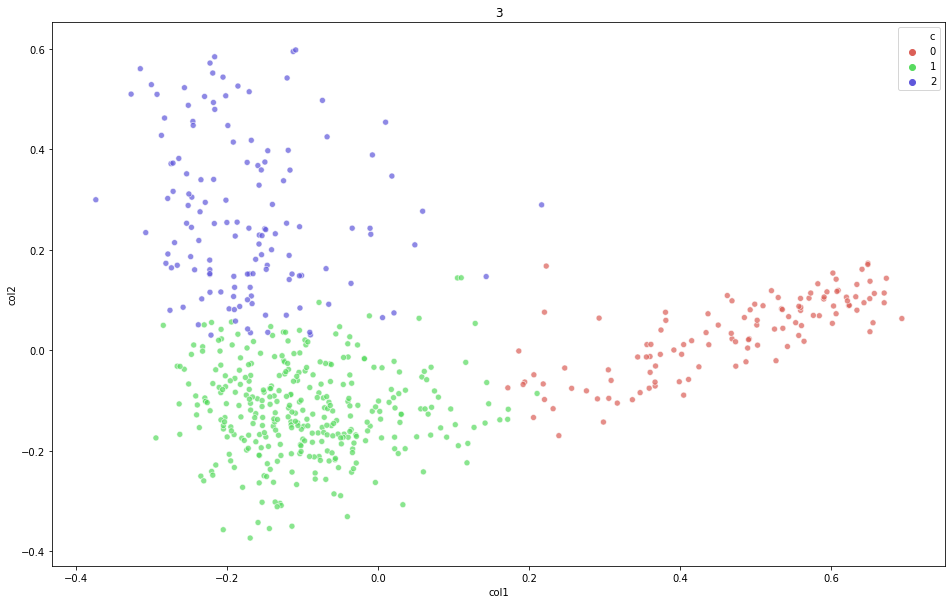

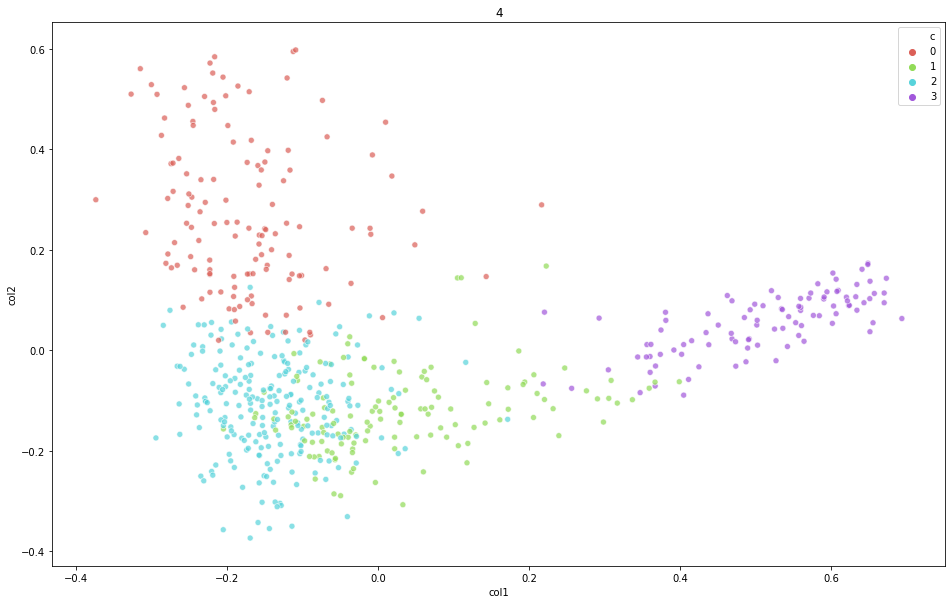

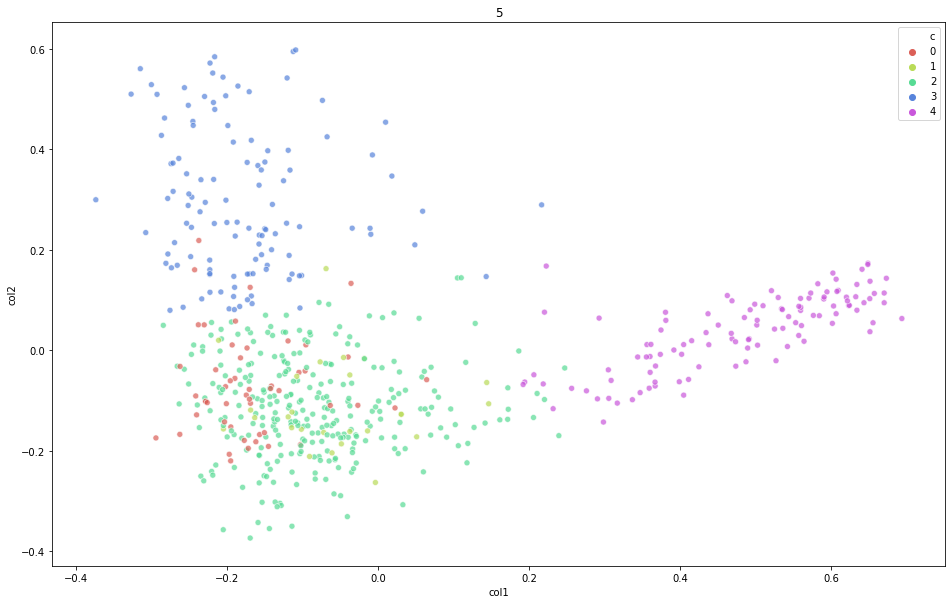

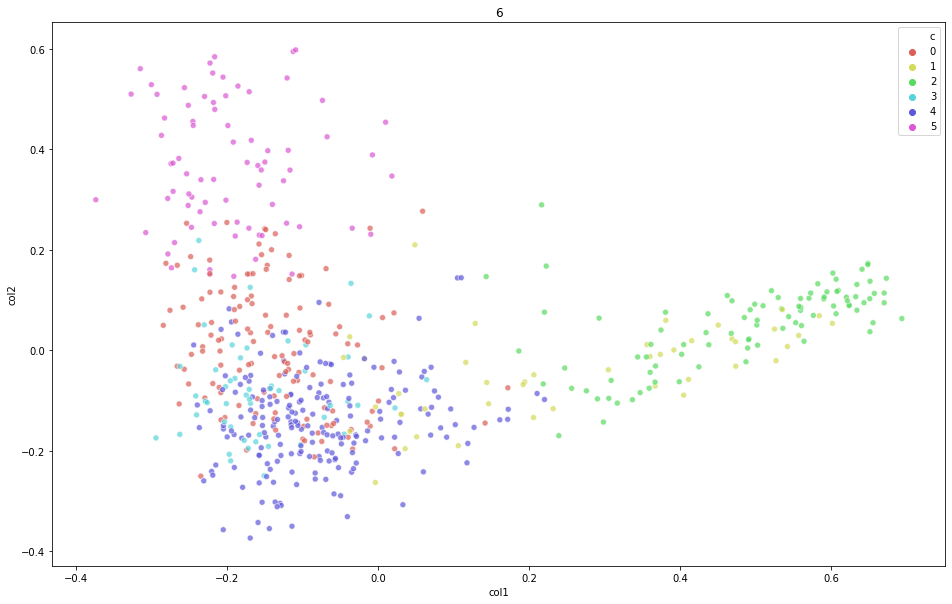

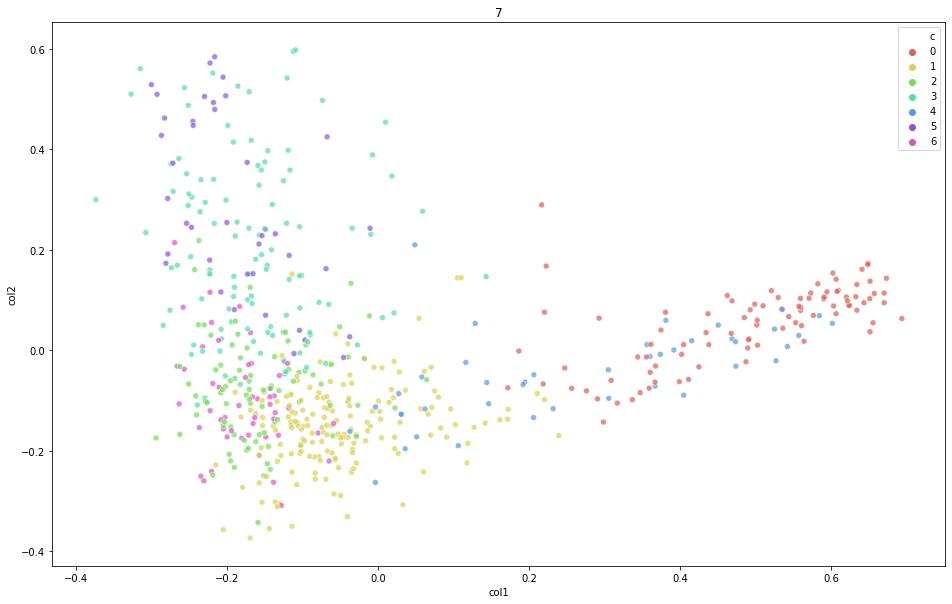

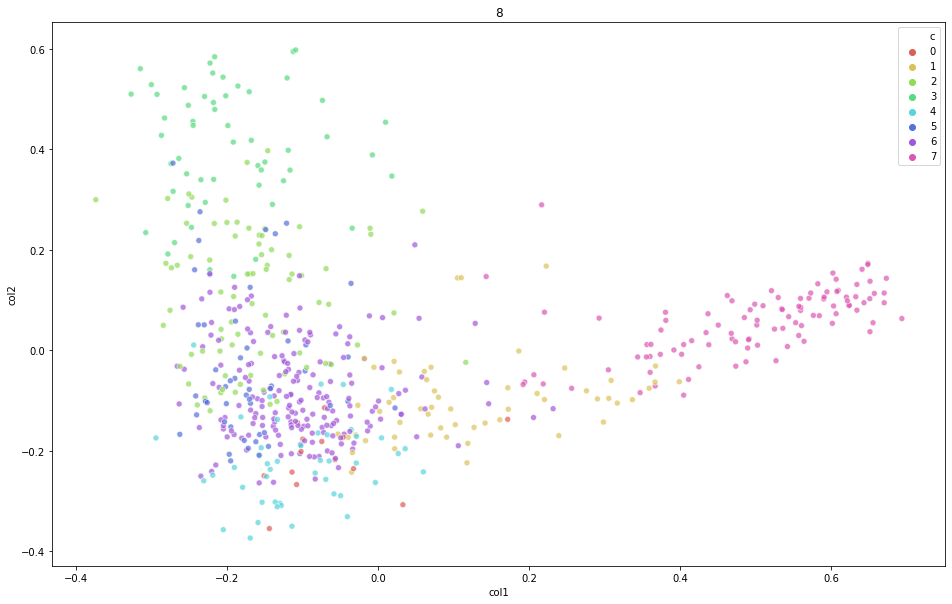

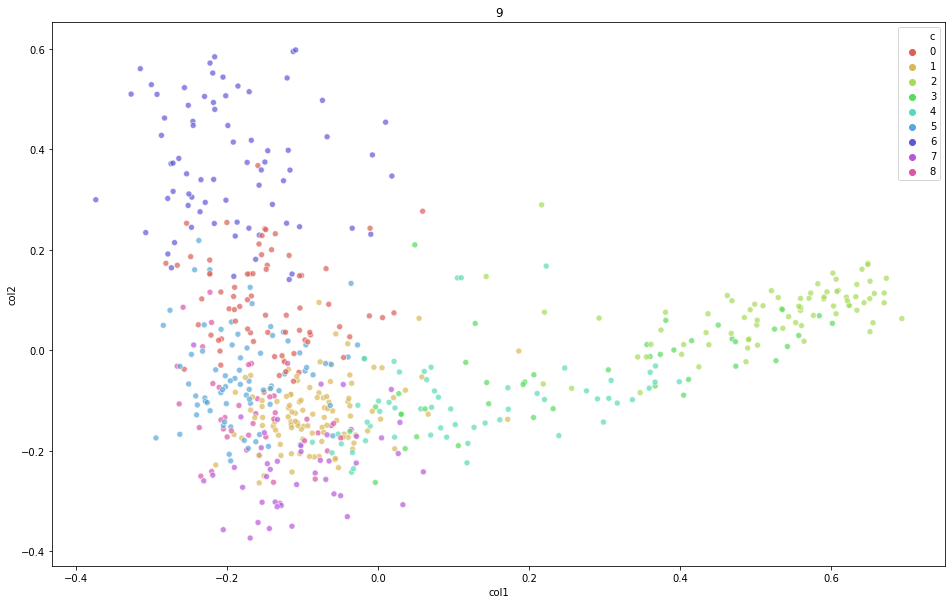

In [68]:
def printgmm(n):
    gmm = mixture.GaussianMixture(n_components=n)
    labels = gmm.fit_predict(X)
    pca_df['c'] = labels
    plt.figure(figsize=(16,10))

    return sns.scatterplot(
        x="col1", y="col2",
        hue="c",
        palette=sns.color_palette("hls", len(set(labels))),
        data=pca_df,
        legend="full",
        alpha=0.7
    ).set_title(n)

for n in range(1, 10):
    printgmm(n)

plt.show()

In [69]:
# covariance_type='tied'

df = pd.DataFrame()
for n in range(1,10):
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='tied')
    labels = gmm.fit_predict(X)
    df.loc[n, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[n, metric_key] =  metrices[metric_key](X, labels)
        except:
            print(":(", metric_key, n)
df

:( silhouette 1


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
1,1.0,inf,1.319530,0.000000,0.933880,NaN
2,2.0,0.767523,1.179657,0.153091,0.832819,0.044267
3,3.0,0.704535,1.183245,0.131313,0.834659,0.050708
4,4.0,0.467027,1.201145,0.118034,0.847094,0.054083
5,5.0,0.654544,1.227888,0.113919,0.866179,0.059369
6,6.0,0.659327,1.179860,0.112495,0.830159,0.046112
7,7.0,0.567902,1.201769,0.099893,0.844607,0.061497
8,8.0,0.565607,1.189009,0.115927,0.835695,0.047423
9,9.0,0.442712,1.189996,0.109062,0.835704,0.054824


In [70]:
# covariance_type='diag'

df = pd.DataFrame()
for n in range(1,10):
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='diag')
    labels = gmm.fit_predict(X)
    df.loc[n, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[n, metric_key] =  metrices[metric_key](X, labels)
        except:
            print(":(", metric_key, n)
df

:( silhouette 1


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
1,1.0,inf,1.319530,0.000000,0.933880,NaN
2,2.0,0.710173,1.213623,0.118169,0.856434,0.042562
3,3.0,0.414154,1.239723,0.109730,0.875234,0.046956
4,4.0,0.442712,1.242087,0.114181,0.876304,0.040240
5,5.0,0.611359,1.247827,0.101016,0.879923,0.044638
6,6.0,0.567902,1.212525,0.130609,0.852858,0.010983
7,7.0,0.467027,1.222516,0.115585,0.859281,0.009710
8,8.0,0.467027,1.239827,0.104940,0.870966,0.034169
9,9.0,0.467027,1.246016,0.082415,0.874741,0.036365


In [71]:
# covariance_type='spherical'

df = pd.DataFrame()
for n in range(1,10):
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='spherical')
    labels = gmm.fit_predict(X)
    df.loc[n, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[n, metric_key] =  metrices[metric_key](X, labels)
        except:
            print(":(", metric_key, n)
df

:( silhouette 1


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
1,1.0,inf,1.319530,0.000000,0.933880,NaN
2,2.0,0.622843,1.146582,0.185581,0.809483,0.037460
3,3.0,0.567902,1.152166,0.155840,0.812458,0.043437
4,4.0,0.567902,1.173881,0.141810,0.828016,0.048324
5,5.0,0.567902,1.175737,0.150450,0.829123,0.041923
6,6.0,0.567902,1.136813,0.113714,0.798233,0.040810
7,7.0,0.576628,1.130719,0.105354,0.791268,0.038739
8,8.0,0.651906,1.136901,0.111389,0.796390,0.046185
9,9.0,0.483280,1.169959,0.111913,0.820343,0.049052


Najlepiej sprawdza się wartość domyślna (full), ew. tied